# Heterogeneous spreading
Notebook on joint work with Liubov, Gael, Flavio and Petter.


In [1]:
import networkx as nx
import random
import numpy as np
import matplotlib.pyplot as plt
#from joblib import Parallel, delayed
#import multiprocessing

def first_infection(G,list_infected=[],list_recovered=[]):
    """
    Apply the first infection on a given graph.

    Args:
        G (Graph): 
        list_infected (list): List of first infected nodes
        list_recovered (list): List of first recovered nodes

    Returns:
        Graph: Graph corresponding to the initial state of the epidemic process

    """
    
    # Set the state of nodes to 'S' and the state of edges to 'SS'
    nx.set_node_attributes(G,'S','state')
    nx.set_edge_attributes(G,'SS','state')
    
    # Infect randomly a node if none are given, or infect the one given
    if len(list_infected)==0:
        N=G.number_of_nodes()
        N0=random.randint(0,N-1)
        G.nodes[N0]['state']='I'
        list_infected=[N0]
    else:
        for node in list_infected:
            G.nodes[node]['state']='I'

    # Infect the neighbor edge of the infected nodes
    for node1 in list_infected:
        for node2 in list(G.neighbors(node1)):
            n1,n2=sorted([node1,node2])
            G[n1][n2]['state']=G.nodes[n1]['state']+G.nodes[n2]['state']

    # If a list of recovered nodes is given, add the information    
    for node1 in list_recovered:
        G.nodes[node1]['state']='R'

        for node2 in list(G.neighbors(node1)):
            n1,n2=sorted([node1,node2])
            G[n1][n2]['state']=G.nodes[n1]['state']+G.nodes[n2]['state']
          
    return G


def create_watts_strogatz_graph(n,k,p,seed,beta,gamma,list_infected=[],list_recovered=[],list_heterogeneous_nodes=[],
                 list_heterogeneous_edges=[],heterogeneous_nodes_weight=[],heterogeneous_edges_weight=[]):
    
    """
    Create a Watts-Strogatz graph and apply the first infection on it.

    Args:
        n (int): Number of nodes of the Watts-Strogatz graph
        k (int): Number of neighbors (nearest) of the Watts-Strogatz graph
        p (float): Probability to rewire a link of the Watts-Strogatz graph
        seed (int): Random seed of the Watts-Strogatz graph
        beta (float): Infection rate 
        gamma (float): Recovery rate
        list_infected (list): List of first infected nodes
        list_recovered (list): List of first recovered nodes
        list_heterogeneous_nodes (list): List of heterogeneous nodes (with a different gamma)
        list_heterogeneous_edges (list): List of heterogeneous edges (with a different beta)
        heterogeneous_nodes_weight (list): Gamma values associated with the heterogeneous nodes
        heterogeneous_edges_weight (list): Beta values associated with the heterogeneous edges


    Returns:
        Graph: Graph corresponding to the initial state of the epidemic process whom 
        the beta and gamma values have been applied

    """
    
    # Create the graph
    G=nx.watts_strogatz_graph(n,k,p,seed=seed)
    
    # Infect the first nodes and recover nodes if some are given 
    G = first_infection(G,list_infected,list_recovered)
    
    # Apply the beta and gamma values to the edges and nodes
    nx.set_edge_attributes(G,beta,'weight')
    nx.set_node_attributes(G,gamma,'weight')
    for node in range(len(list_heterogeneous_nodes)):
        G.nodes[list_heterogeneous_nodes[node]]['weight']=heterogeneous_nodes_weight[node]
    for node in range(len(list_heterogeneous_edges)):
        G[list_heterogeneous_edges[node][0]][list_heterogeneous_edges[node][1]]['weight']=heterogeneous_edges_weight[node]

    return G

def create_barabasi_albert_graph(n,m,seed,beta,gamma,list_infected=[],list_recovered=[],list_heterogeneous_nodes=[],
                 list_heterogeneous_edges=[],heterogeneous_nodes_weight=[],heterogeneous_edges_weight=[]):
    
    """
    Create a Barabasi-Albert graph and apply the first infection on it.

    Args:
        n (int): Number of nodes of the Barabasi-Albert
        m (int): Number of neighbors (nearest) of the Watts-Strogatz graph
        seed (int): Random seed of the Barabasi-Albert graph
        beta (float): Infection rate 
        gamma (float): Recovery rate
        list_infected (list): List of first infected nodes
        list_recovered (list): List of first recovered nodes
        list_heterogeneous_nodes (list): List of heterogeneous nodes (with a different gamma)
        list_heterogeneous_edges (list): List of heterogeneous edges (with a different beta)
        heterogeneous_nodes_weight (list): Gamma values associated with the heterogeneous nodes
        heterogeneous_edges_weight (list): Beta values associated with the heterogeneous edges


    Returns:
        Graph: Graph corresponding to the initial state of the epidemic process whom 
        the beta and gamma values have been applied

    """
    
    # Create the graph
    G=nx.barabasi_albert_graph(n,m,seed)
    
    # Infect the first nodes and recover nodes if some are given 
    G = first_infection(G,list_infected,list_recovered)
    
    # Apply the beta and gamma values to the edges and nodes
    nx.set_edge_attributes(G,beta,'weight')
    nx.set_node_attributes(G,gamma,'weight')
    for node in range(len(list_heterogeneous_nodes)):
        G.nodes[list_heterogeneous_nodes[node]]['weight']=heterogeneous_nodes_weight[node]
    for node in range(len(list_heterogeneous_edges)):
        G[list_heterogeneous_edges[node][0]][list_heterogeneous_edges[node][1]]['weight']=heterogeneous_edges_weight[node]

    return G

def run_one_infection_step(G,t):

    """
    Run one infection step using gillespie algorithm. 
    All the possible events and their weigths are extracted from the graph,
    then one event is choosen randomly,proportionally to its weight.

    Args:
        G (Graph): Graph of the current state of the epidemic process
        t (float): Time already spent of the epidemic process

    Returns:
        Graph: Graph corresponding to the following state of the epidemic process
        float: Updated time of the epidemic process

    """
    
    # Get the state of the nodes and the edges
    state_nodes = nx.get_node_attributes(G, 'state')
    state_edges = nx.get_edge_attributes(G, 'state')
    
    #Get the infected nodes and edges
    infectious_edges = [edge for edge,state in state_edges.items() if state in ['SI','IS']]
    infectious_nodes = [node for node,state in state_nodes.items() if state == 'I']
    nb_edges = len(infectious_edges)
    

    # Compute the weight of the possible event and compute the time until the
    # first happens
    k=[G[edge[0]][edge[1]]['weight'] for edge in infectious_edges] + [G.nodes[node]['weight'] for node in infectious_nodes]
    k_tot=sum(k)
    
    # Draw the time-step from an exponential distribution
    t_exp=np.random.exponential(scale=1/k_tot,size=None)
    
    ## Choose which action will be done (infection or recovery)
    
    # Draw a random number between 0 and 1
    random_nb = random.random()
    
    # Get the position of the action
    action_loc=0
    action_sum=k[0]/k_tot
    while random_nb>action_sum:
        action_loc= action_loc + 1
        action_sum = action_sum + k[action_loc]/k_tot
    
    if action_loc < nb_edges:    
        
        # Infected the selected nodes
        n1=action_loc
        node1=infectious_edges[n1][0]
        node2=infectious_edges[n1][1]
        G[node1][node2]['state']='II'
        
        action = infectious_edges[n1]
        
        # Get the new infected node
        if node1 in infectious_nodes:
            new_node = node2
        else:
            new_node = node1
        
        # Change the state of the node
        G.nodes[new_node]['state']='I'
        
    else:
        # Recover the selected node
        n1=action_loc-nb_edges
        node1=infectious_nodes[n1]
        action = infectious_nodes[n1]
        
        # Change the state of the node and the edges link to this node
        G.nodes[node1]['state']='R'
        new_node=node1
    
    # Change the state of the links connected to changed nodes
    neighbors = list(G.neighbors(new_node))
    for neighbor in neighbors:
        if new_node < neighbor:
            G[new_node][neighbor]['state']=G.nodes[new_node]['state']+G.nodes[neighbor]['state']
        else:
            G[neighbor][new_node]['state']=G.nodes[neighbor]['state']+G.nodes[new_node]['state']
    
    # Update the time
    t=t+t_exp
    return G,t,action


def run_simulation(G,t0,tmax):
    
    """
    Run the simulation the epidemic process on the given graph until no infection or
    recovery are possible or until the time exceed the maximum given.
    Args:
        G (Graph): Graph of the initial state of the epidemic process
        t0 (float): Initial time
        tmax (float): Maximum time
    Returns:
        list: List of the times of all the step
        list: List of the nodes state of all the step

    """
    
    # Get the initial state of the nodes
    state_nodes = nx.get_node_attributes(G, 'state')
    
    # Initialize the time and the list used to store the results
    sim_times=[t0]
    sim_nodes=[state_nodes]
    sim_actions=[]
    t=t0
    
    # Run the simulation
    while t<tmax+1:
        # Run one step of the epidemic process
        G,t,action=run_one_infection_step(G,t)
        
        # Get the stade of the nodes an add them to the list
        state_nodes = nx.get_node_attributes(G, 'state')
        state_edges = nx.get_edge_attributes(G, 'state')
        sim_times.append(t)
        sim_nodes.append(state_nodes)
        sim_actions.append(action)
        
        # Stop the simulation if no more nodes and edges are infected        
        if len([node for node,state in state_nodes.items() if state == 'I'])==0 and len([edge for edge,state in state_edges.items() if state in ['SI','IS']])==0:
            break

    return sim_times,sim_nodes,sim_actions


def get_pos(pos,shortest_path,ring,node,angle,angle_witdh):
    
    """

    Args:
        pos (dict): Position of the nodes
        shortest_path (dict): Shortest path of the nodes to the central node
        ring (int): Distance of the current node to the central node
        node (int): Node that will be used
        angle (float): Angle of the current node
        angle_width (float): Correspond to the space available to put the further nodes

    Returns:
        dict: Position of the nodes after the current step

    """
    
    # Get the nodes of the next ring that have the given node in their shortest path
    list_nodes = [n for n,path in shortest_path.items() if (len(path)==ring+2 and path[-2]==node)]
    
    # If nodes fullfill this requirement, compute their position and iterate with 
    # them as "first node" of the iteration
    
    nb_nodes = len(list_nodes)
    if nb_nodes==0:
        return pos
    else:
        new_angle_witdh = angle_witdh/nb_nodes
        for i in range(nb_nodes):
            new_node = list_nodes[i]
            new_angle = angle-angle_witdh/2+new_angle_witdh*(i+0.5)
            new_ring = ring+1
            pos[new_node] = (new_ring*np.cos(new_angle),new_ring*np.sin(new_angle))
            pos = get_pos(pos,shortest_path,new_ring,new_node,new_angle,new_angle_witdh)
    
        return pos
    
def central_layout(G,central_node):
    
    """
    Compute a layout based on the distance to a central nodes. Each node is located 
    to a distance proportional to it distance to the central node.
    
    The way it works: it first get the position of the nodes with distance 1, then it
    iterate over higher distance (2 then 3 then 4,...) and each nodes is put close
    to the penultimate node of it shortest path list.
    
    This able to reduce the link that cross each other. It a first optimization step
    but the function has not been fully optimized.

    Args:
        G (Graph): Graph of the initial state of the epidemic process
        central_node (int): Central node of the layout

    Returns:
        dict: Position of the nodes in a 2D space

    """
    
    # Get the shortest path from the nodes to the central node
    N=G.number_of_nodes()
    shortest_path = nx.shortest_path(G,central_node)
    shortest_path = {i:shortest_path[i] for i in sorted(shortest_path)}
    
    # Initialize the dictionnary that will contain the position
    pos = {i:(0,0) for i in range(N)}
    
    # Get the nodes with distance 1 and give them an angle
    list_paths=[path for node,path in shortest_path.items() if len(path)==2]
    len_paths=len(list_paths)
    angle_witdh = 2*np.pi/len_paths
    
    # For each node with distance one, compute the position of the nodes that have
    # the node in their shortest path
    for j in range(len_paths):
        node=list_paths[j][-1]
        angle = 2*np.pi*j/len_paths
        pos[node]=(np.cos(angle),np.sin(angle))
        pos = get_pos(pos,shortest_path,1,node,angle,angle_witdh)

    return pos

def extinction_time(N,t0,tmax,sim_times,sim_nodes,sim_actions):
    
    """
    Compute the extinction time of the epidemic process

    Args:
        N (int): Number of the node in the graph
        t0 (float): Initial time
        tmax (float): Maximum time
        sim_times (list): List of the times of the simulation: from function run_simulation model
        sim_nodes (list): List of the state of the nodes
        sim_actions (list): List of the actions (int if recovery, tuple if infection)     
        
    Returns:
        float: Extinction time (time of the last step)

    """
    
    return sim_times[-1]

def arrival_time(N,t0,tmax,sim_times,sim_nodes,sim_actions):
    
    """
    Compute the extinction time of the epidemic process

    Args:
        N (int): Number of the node in the graph
        t0 (float): Initial time
        tmax (float): Maximum time
        sim_times (list): List of the times of the simulation
        sim_nodes (list): List of the state of the nodes
        sim_actions (list): List of the actions (int if recovery, tuple if infection)
        
    Returns:
        float: Extinction time (time of the last step)

    """
    
    matrix=np.zeros(N)
    for i in range(len(sim_actions)):
        action = sim_actions[i]
        prev_state = sim_nodes[i]
        if type(action)==tuple:
            n1=action[0]
            n2=action[1]
            if prev_state[n1]=='S':
                matrix[n1]=sim_times[i+1]
            else:
                matrix[n2]=sim_times[i+1]
    
    return matrix

def end_number_S(N,t0,tmax,sim_times,sim_nodes,sim_actions):
    
    """
    Compute the number of S at the end of the epidemic process

    Args:
        N (int): Number of the node in the graph
        t0 (float): Initial time
        tmax (float): Maximum time
        sim_times (list): List of the times of the simulation
        sim_nodes (list): List of the state of the nodes 
        sim_actions (list): List of the actions (int if recovery, tuple if infection)
        
    Returns:
        int: Number of S at the end

    """
    
    print(len([node for node,state in sim_nodes[-1].items() if state == 'S']))
    
    return len([node for node,state in sim_nodes[-1].items() if state == 'S'])


def proba_be_infected_after_t(N,t0,tmax,sim_times,sim_nodes,sim_actions):

    """
    Compute the extinction time of the epidemic process

    Args:
        N (int): Number of the node in the graph
        t0 (float): Initial time
        tmax (float): Maximum time
        sim_times (list): List of the times of the simulation
        sim_nodes (list): List of the state of the nodes 
        sim_actions (list): List of the actions (int if recovery, tuple if infection)
        
    Returns:
        matrix: Matrix of the probability to be infected (0 or 1) at every time step

    """

    # Go through each time (0,1,...N) and look if the nodes where infected and store it
    # in a matrix
    sim_times=np.array(sim_times)
    matrix= np.zeros([tmax+1,N])
    for t in range(tmax+1):
        if t<=sim_times[-1]:
            sim_t = sim_times[sim_times>=t][0]
            index = np.where(sim_times == sim_t)[0][0]
            for j in range(N):
                if list(sim_nodes[index].values())[j] == 'I':
                    matrix[t,j] = 1
    return matrix

def proba_be_infected(N,t0,tmax,sim_times,sim_nodes,sim_actions):
    
    """
    Compute the extinction time of the epidemic process

    Args:
        N (int): Number of the node in the graph
        t0 (float): Initial time
        tmax (float): Maximum time
        sim_times (list): List of the times of the simulation
        sim_nodes (list): List of the state of the nodes 
        sim_actions (list): List of the actions (int if recovery, tuple if infection)
        
    Returns:
        array: Array of the probability to be infected (0 or 1)

    """
    
    matrix=np.zeros(N)
    for j in range(N):
        if list(sim_nodes[-1].values())[j] in ['R','I']:
            matrix[j] = 1
    return matrix

def outbreak_time(N,t0,tmax,sim_times,sim_nodes,sim_actions):
    
    """
    Compute the time of the maximum number of I that were present at one point, called outbreak time

    Args:
        N (int): Number of the node in the graph
        t0 (float): Initial time
        tmax (float): Maximum time
        sim_times (list): List of the times of the simulation
        sim_nodes (list): List of the state of the nodes 
        sim_actions (list): List of the actions (int if recovery, tuple if infection)
        
    Returns:
        float: Time of the outbreak
    """
    
    nb_steps = len(sim_times)
    matrix=np.zeros([nb_steps])
    for i in range(nb_steps):
        matrix[i] = len([node for node,state in sim_nodes[i].items() if state in ['I']])
    
    return sim_times[np.argmax(matrix)]

def outbreak_size(N,t0,tmax,sim_times,sim_nodes,sim_actions):
    
    """
    Compute the maximum number of I that were present at one point, called outbreak size

    Args:
        N (int): Number of the node in the graph
        t0 (float): Initial time
        tmax (float): Maximum time
        sim_times (list): List of the times of the simulation
        sim_nodes (list): List of the state of the nodes 
        sim_actions (list): List of the actions (int if recovery, tuple if infection)
        
    Returns:
        float: Size of the outbreak
    """
    
    nb_steps = len(sim_times)
    matrix=np.zeros([nb_steps])
    for i in range(nb_steps):
        matrix[i] = len([node for node,state in sim_nodes[i].items() if state in ['I']])
    
    return max(matrix)

def direction(N,t0,tmax,sim_times,sim_nodes,sim_actions):
    """
    For each node that has been infected, get the set of edges taken from the first infected nodes
    
    Args:
        N (int): Number of the node in the graph
        t0 (float): Initial time
        tmax (float): Maximum time
        sim_times (list): List of the times of the simulation
        sim_nodes (list): List of the state of the nodes 
        sim_actions (list): List of the actions (int if recovery, tuple if infection)
        
    Returns:
        list: List of the set of edges taken
    """
    
    list_direction = [[] for i in range(N)]
    for action_i in range(len(sim_actions)):
        action = sim_actions[action_i]
        if type(action) == tuple:
            state = sim_nodes[action_i]
            n1=action[0]
            n2=action[1]
            
            if state[n1]=='I' and state[n2]=='S':
                old_node=n1
                new_node=n2
            else:
                old_node=n2
                new_node=n1
            
            if action_i==0:
                list_direction[old_node]=[old_node]
            
            list_direction[new_node] = list_direction[old_node]+[new_node]
            
    return list_direction

def last_direction(N,t0,tmax,sim_times,sim_nodes,sim_actions):
    """
    For each node that has been infected, get the node that infected it
    
    Args:
        N (int): Number of the node in the graph
        t0 (float): Initial time
        tmax (float): Maximum time
        sim_times (list): List of the times of the simulation
        sim_nodes (list): List of the state of the nodes 
        sim_actions (list): List of the actions (int if recovery, tuple if infection)
        
    Returns:
        matrix
    """
    
    matrix=np.zeros([N,N])
    for action_i in range(len(sim_actions)):
        action = sim_actions[action_i]
        state = sim_nodes[action_i]
        if type(action) == tuple:
            n1=action[0]
            n2=action[1]
            if state[n1]=='I' and state[n2]=='S':
                matrix[n1,n2] = 1
            else:
                matrix[n2,n1] = 1
            
    return matrix

def compute_measure(G0,t0,tmax,list_measure):
    
    """
    Compute measures about the epidemic process

    Args:
        G0 (Graph): Graph of the initial state of the epidemic process
        t0 (float): Initial time
        tmax (float): Maximum time
        list_measure (list): List of functions used to compute meaures about
                             the epidemic process
        
    Returns:
        array: Array of the probability to be infected (0 or 1)

    """
    
    # This is necessary to be sure that G and G0 are not stored in the same merory place. 
    # Otherwise, the initial graph will be lost.
    G=G0.copy()    
    N=G.number_of_nodes()
    
    # Run one simulation
    sim_times,sim_nodes,sim_actions = run_simulation(G,t0,tmax)
    
    results=[]
    for measure in list_measure:
        results.append(measure(N,t0,tmax,sim_times,sim_nodes,sim_actions))
        
    return results
    

def measure_analysis(G0,t0,tmax,list_measure,nb_simulation):
    
    """
    Compute a measure of the epidemic process for several simulations

    Args:
        G (Graph): Graph of the initial state of the epidemic process
        t0 (float): Initial time
        tmax (float): Maximum time
        measure (function) : Function used to compute a results over the epidemic process
        nb_simulation (int) : Number of simulation
        
    Returns:
        matrix: Resulting measure for all the simulations

    """
    
    # Get the number of available cores to run the code in parallel
    num_cores = multiprocessing.cpu_count()-1
    
    # Run the code in parallel for the given measures
    results = Parallel(n_jobs=num_cores)(delayed(compute_measure)(G0,t0,tmax,list_measure) for i in range(nb_simulation))
    
    return results

def plot_heatmap(matrix,range1,range2,range1_label,range2_label,legend,title,size=10,savefig=True,filename="heatmap.png"):
    
    """
    Plot a heatmap

    Args:
        matrix (matrix): Values to be plot
        range1 (list): Values of the x axis
        range2 (list): Values of the y axis
        range1_label (str): Label of the x axis
        range2_label (str): Label of the y axis
        legend (str): Legend of the colormap (values of the matrix)
        title (str): Title of the figure
        filename (str): Name of the directory to save the figure
        size (int): Size of the figure
        savefig (bool): Boolean to know if the user want to save the figure
        
    Returns:
        None

    """
    
    # Create the figure
    plt.figure(figsize=(size,size))
    plt.imshow(np.transpose(matrix),cmap='RdYlGn_r')
    
    # Add the colorbar
    cbar=plt.colorbar()
    cbar.ax.tick_params(labelsize=2*size) 
    cbar.set_label(legend,fontsize=2*size)
    
    # Add labels and title
    plt.xticks(range(0,len(range1)),labels=range1,fontsize=size)
    plt.yticks(range(0,len(range2)),labels=range2,fontsize=size)
    plt.xlabel(range1_label,fontsize=2*size)
    plt.ylabel(range2_label,fontsize=2*size)
    plt.title(title,fontsize=2*size)
    
    # Save the figure
    if savefig:
        plt.tight_layout()
        plt.savefig(filename)
        
def plot_graph(G,pos,val=None,min_val=None,max_val=None,node_size=1,node_color=None,legend="",title="",plot_ring=False,with_labels=True,savefig=True,filename="graph.png"):
    
    """
    Plot a heatmap

    Args:
        G (Graph): The graph to be plotted
        matrix (matrix): Values to be plotted 
        range1 (list): Values corresponding to the each graph
        range1_label (str): Label of the range
        legend (str): Legend of the colormap (values of the matrix)
        title (str): Title of the figure
        filename (str): Name of the directory to save the figure
        size (int): Size of the figure
        savefig (bool): Boolean to know if the user want to save the figure
        
    Returns:
        None

    """
    
    N=G.number_of_nodes()
    size=30
    
    # Create the figure and plot the nodes, edges and labels
    fig=plt.figure(figsize=(1.5*size,size))
    ax=fig.add_subplot(1,1,1)
    
    # Add circles to delimit the nodes based on the distance to the center node
    if plot_ring:
        max_distance = int(max([np.sqrt(val[0]**2+val[1]**2) for val in pos.values()])+1)
    
        for i in range(max_distance):
            ax.add_artist(plt.Circle((0,0),max_distance-i-0.5,color='c',fill=False,linewidth=size/3))
        plt.xlim([0.4-max_distance,max_distance-0.4])
        plt.ylim([0.4-max_distance,max_distance-0.4])
        
    nx.draw_networkx_edges(G, pos,width=size/10)
    if type(node_color)!=type(None):
        nx.draw_networkx_nodes(G,pos=pos,node_color=node_color,node_size=10000*size*node_size/N)

    else:
        im=nx.draw_networkx_nodes(G,pos=pos,node_color=val,cmap='RdYlGn_r',vmin=min_val,vmax=max_val,node_size=10000*size*node_size/N)
    
    if with_labels:
        nx.draw_networkx_labels(G,pos,{i:str(i) for i in range(N)},font_size=1000*size*node_size/N)

    # Modify the structure of the plot and add information
    plt.axis('off')
    if type(val)!=type(None):
        fig.subplots_adjust(right=0.8)
        cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
        cbar=fig.colorbar(im, cax=cbar_ax)
        cbar.ax.tick_params(labelsize=2*size)
    fig.suptitle(title,size=2*size)

    # Save the figure
    if savefig:
        plt.savefig(filename)
        
def all_path(G1,node1,node2,step,step_max):
    to_return=[]
    if step <= step_max:
        try:
            shortest_path=nx.shortest_path(G1,node1,node2)
        except :
            return to_return
        to_return.append('.'.join(str(e) for e in shortest_path))
        for i in range(len(shortest_path)-1):
            G2=G1
            G2.remove_edge(shortest_path[i],shortest_path[i+1])
            to_return=to_return+all_path(G2,node1,node2,step+1,step_max)
            G2.add_edge(shortest_path[i],shortest_path[i+1])
        
    return list(set(to_return))


def node_conditionnal_BC(G,first_infected):
    
    """
    Compute the conditionnal betweenness centrality for the nodes : compute normal BC but
    only for shortest path starting from one node
    
    Args:
        G (Graph): The graph
        first_infected (int): Source node to look at

    Returns:
        array

    """
    
    n=G.number_of_nodes()
    measure = np.zeros(n)

    weight = nx.get_edge_attributes(G, 'weight')
    distance = {i:np.divide(1,weight[i]) for i in weight.keys()}
    nx.set_edge_attributes(G,distance,'distance')

    for node1 in range(n):
        if node1 != first_infected:      
            all_sp = list(nx.all_shortest_paths(G,first_infected,node1,weight='distance'))
            measure_node = np.zeros(n)
            for sp in all_sp:
                for node2 in sp:
                    measure_node[node2] = measure_node[node2] +1 
            measure = measure + measure_node/len(all_sp)
    measure = measure/(n-1)
    
    return measure

def edge_conditionnal_BC(G,first_infected):
    
    """
    Compute the conditionnal betweenness centrality for the edges : compute normal BC but
    only for shortest path starting from one node
    
    Args:
        G (Graph): The graph
        first_infected (int): Source node to look at

    Returns:
        array

    """
    
    list_edges = list(G.edges())
    n1=len(list_edges)
    measure = np.zeros(n1)

    weight = nx.get_edge_attributes(G, 'weight')
    distance = {i:np.divide(1,weight[i]) for i in weight.keys()}
    nx.set_edge_attributes(G,distance,'distance')

    n2 = G.number_of_nodes()
    
    for node1 in range(n2):
        if node1 != first_infected:      
            all_sp = list(nx.all_shortest_paths(G,first_infected,node1,weight='distance'))
            measure_edges = np.zeros(n1)
            for sp in all_sp:
                for i in range(len(sp)-1):
                    edge = tuple(sorted((sp[i],sp[i+1])))
                    edge_index = list_edges.index(edge)
                    measure_edges[edge_index] = measure_edges[edge_index] +1 
            measure = measure + measure_edges/len(all_sp)
    measure = measure/(n2-1)
    
    return measure



# Effective distance network measure

Estimation of effective distance and mean first passage time.

In [2]:

import numpy as np
#import matplotlib as plt 
#import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
#from matplotlib.patches import FancyArrowPatch, Circle
#import csv
import random
import scipy
#import seaborn as sns
from math import exp, expm1 
import math


def submatr(matrix1, j):  #matrix without jth column and jth row 
    #To delete the jth column
    matrix_del = np.delete(matrix1,(j-1), axis=1)
    return np.delete(matrix_del,(j-1), axis=0)
     

def matr_inv_elem(beta, beta_ij, P_matr, lambda_val, N, i_ind, k_ind, j_ind ):  #ith, kth element of inverse matrix   
    matr_inv = np.linalg.inv(np.identity(N-1) - np.exp(-lambda_val) * submatr(P_matr, j_ind)) #homogeneous effective distace
    matr_elem = matr_inv[i_ind,k_ind]
    return matr_elem



def effective_distance(G,first_infected,beta):
    
    """
    Compute the effective distance
    
    Args:
        G (Graph): The graph
        first_infected (int): Source node to look at

    Returns:
        array

    """
    
    n=G.number_of_nodes()
    measure = np.zeros(n)

    weight = nx.get_edge_attributes(G, 'weight')
    distance = {i:np.divide(1,weight[i]) for i in weight.keys()}
    nx.set_edge_attributes(G,distance,'distance')

    all_length = dict(nx.all_pairs_dijkstra_path_length(G,weight='distance'))[first_infected]

    for node1 in range(n):
        measure[node1]=all_length[node1]
    measure=measure
    return measure

def effective_BC(G):
    
    """
    Compute the effective betweenness centrality
    
    Args:
        G (Graph): The graph
        first_infected (int): Source node to look at

    Returns:
        array

    """
    
    n=G.number_of_nodes()
    measure = np.zeros(n)

    weight = nx.get_edge_attributes(G, 'weight')
    distance = {i:np.divide(1,weight[i]) for i in weight.keys()}
    nx.set_edge_attributes(G,distance,'distance')

    bc=nx.betweenness_centrality(G,weight='distance')

    for node1 in range(n):
        measure[node1]=bc[node1]
    return measure

def eff_dist(beta, beta_ij, P_matr, N,lambda_val, i_ind, j_ind): #function to calculate effective distance analytically
    '''
    eff.distance between nodes i_ind and j_ind
    N is size of matrix
    
    P_matr is Markov chain matrix, 
    which is defined from degree matrix:
    P_ij = 1/deg(i)
    
    limit for lambda -> 0 is calculated for small lambda value
    '''

    
    P_matr_j = submatr(P_matr, j_ind)
    P_matr_col = P_matr[j_ind,:]
    
#    x = range(T_wind) #number of steps
    k_ind = 10 
    eff_dist_comp = matr_inv_elem(beta, beta_ij, P_matr, lambda_val, N, i_ind, k_ind, j_ind ) * exp(-lambda_val)*P_matr_col[k_ind]
    sum_comp =  sum(matr_inv_elem(beta, beta_ij, P_matr, lambda_val, N, i_ind, k_ind, j_ind ) * exp(-lambda_val)*P_matr_col[k_ind] for k_ind in range(1,N-1))
    eff_dist = -np.log(sum_comp) 
    eff_dist_het = eff_dist #* beta_ij
    
    return eff_dist_het


# Setup networks and epidemics spreading

Importantly, when we setup networks in functions create_watts_strogatz_graph we set heterogeneous nodes in the list `list_heterogeneous_edges`, which sets list of heterogeneous edges (with a different beta).

In [17]:
#setup parameters
n =100 # number of nodes 
k = 4 
p = 0.5  #parameter of WS network
seed =10 #random seed

m = 4 # parameter of BA network

# parameter of spreading
beta = 0.2 
gamma = 0.2 

# time for simulations 
t0 = 0 
tmax = 10000


# Create heterogeneous graph
Heterogeneous graph with list of heterogeneous nodes. 
Algorithm:
1. make a homogeneous network 
2. make a heterogeneities in a network 

0
[0.9 0.9 0.9]
<class 'networkx.classes.graph.Graph'>


Text(0.5, 1.0, 'Outbreak size')

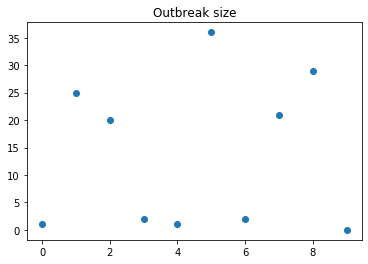

In [18]:


#make a homogeneous network 
G_WS = create_watts_strogatz_graph(n,k,p, seed, beta,gamma)

#G_BA = create_barabasi_albert_graph(n,m,seed,beta,gamma)

list_heterogeneous_node = [1]  # one heterogeneous node induced
#heter_edges_weight=[0.5*np.ones(n)]
#print(list_heter_edges)
#print(type(heter_edges_weight))


# Define the range of the beta_ij of the heterogeneous node
range_beta = np.arange(0.1,1.0,0.1)

# Create the matrix that will contain the heterogen. nodes
matrix=np.zeros([len(list_heterogeneous_node),len(range_beta),2])

array_outbreak = np.zeros(10) #number of different beta values
 
for i1 in range(len(list_heterogeneous_node)):
    # Print i1 to know the advancement of the code
    print(i1)
    
    # Get the heterogeneous node and it edges
    heterogeneous_node = list_heterogeneous_node[i1]
    list_edges = list(G_WS.edges(heterogeneous_node))
    
    for i2 in range(len(range_beta)):
        ''' create a Graph for each value of heterogeneous beta value'''
        beta_i=range_beta[i2]
        edges_weight = np.ones(len(list_edges))*beta_i

        G_WS_hetero = create_watts_strogatz_graph(n,k,p,seed,beta,gamma,list_infected=[],list_recovered=[], #list_heterogeneous_nodes,
                 list_heterogeneous_edges=list_edges, heterogeneous_edges_weight= edges_weight)

        
        # estimate a measure on a graph 
        
        
        sim_times,sim_nodes,sim_actions = run_simulation(G_WS_hetero, t0, tmax)
        
        array_outbreak[i2] = outbreak_size(n,t0,tmax,sim_times,sim_nodes,sim_actions)
        
        
    print(edges_weight)
    
print(type(G_WS_hetero))
plt.plot(array_outbreak, 'o')
plt.title('Outbreak size for different parameter values for 1 simulation')

# Figure 1:
We plot size of outbreak for each heterogeneous network parameter $\beta_{ij}$ and for different beta heterogeneous parameter $\beta$ fixed for the whole network.

We clearly see, we need to calculate the average value of mean number of affected people and do it for many simulations. 


<class 'networkx.classes.graph.Graph'>


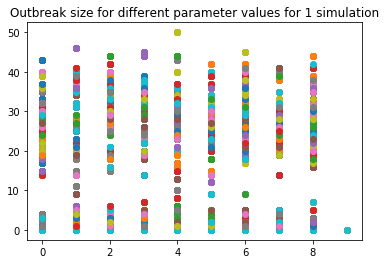

In [24]:

# make simulations 
N_sim = 100
array_outbreak = np.zeros((10, N_sim)) # make new zeros array

for n1 in range(N_sim):
    # Print n1
    #print(n1)
    
    # Get the heterogeneous node and it edges
    heterogeneous_node = list_heterogeneous_node[i1]
    list_edges = list(G_WS.edges(heterogeneous_node))
    
    
     
    for i2 in range(len(range_beta)):
        ''' create a Graph for each value of heterogeneous beta value'''
        beta_i=range_beta[i2]
        edges_weight = np.ones(len(list_edges))*beta_i

        G_WS_hetero = create_watts_strogatz_graph(n,k,p,seed,beta,gamma,list_infected=[],list_recovered=[], #list_heterogeneous_nodes,
                 list_heterogeneous_edges=list_edges, heterogeneous_edges_weight= edges_weight)

        
        # estimate a measure on a graph 
        
        
        sim_times,sim_nodes,sim_actions = run_simulation(G_WS_hetero, t0, tmax)
        
        array_outbreak[i2,n1] = outbreak_size(n,t0,tmax,sim_times,sim_nodes,sim_actions)
        
        plt.plot(array_outbreak, 'o')

        
    #print(edges_weight)
    
print(type(G_WS_hetero))
#plt.plot(array_outbreak, 'o')
plt.title('Outbreak size for different parameter values for 1 simulation')
plt.show()

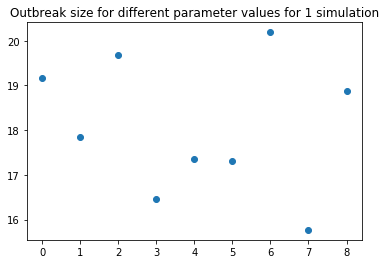

In [29]:
# plot averaged number of nodes infected 

#plt.plot(array_outbreak, 'o')
mean_array = np.mean(array_outbreak, axis=1)
plt.plot(mean_array[0:9], 'o')
plt.title('Outbreak size for different parameter values for 1 simulation')
plt.show()



# Fig. 2: Compute arrival times, temporal measure  





0
<class 'networkx.classes.graph.Graph'>


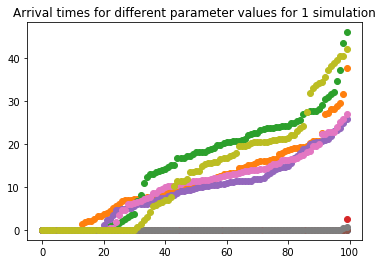

In [37]:


#make a homogeneous network with fixed topology
G_WS = create_watts_strogatz_graph(n,k,p, seed, beta,gamma)

#G_BA = create_barabasi_albert_graph(n,m,seed,beta,gamma)

list_heterogeneous_node = [1]  # one heterogeneous node induced

# Define the range of the beta_ij of the heterogeneous node
range_beta = np.arange(0.1,1.0,0.1)

# Create the matrix that will contain the heterogen. nodes
matrix=np.zeros([len(list_heterogeneous_node),len(range_beta),2])

array_arrivals = np.zeros(10) #number of different beta values
 
for i1 in range(len(list_heterogeneous_node)):
    # Print i1 to know the advancement of the code
    print(i1)
    
    # Get the heterogeneous node and it edges
    heterogeneous_node = list_heterogeneous_node[i1]
    list_edges = list(G_WS.edges(heterogeneous_node))
    
    for i2 in range(len(range_beta)):
        ''' create a Graph for each value of heterogeneous beta value'''
        beta_i=range_beta[i2]
        edges_weight = np.ones(len(list_edges))*beta_i

        G_WS_hetero = create_watts_strogatz_graph(n,k,p,seed,beta,gamma,list_infected=[],list_recovered=[], #list_heterogeneous_nodes,
                 list_heterogeneous_edges=list_edges, heterogeneous_edges_weight= edges_weight)

        
        # estimate a measure on a graph 
        
        sim_times,sim_nodes,sim_actions = run_simulation(G_WS_hetero, t0, tmax)
        
        matrix = arrival_time(n,t0,tmax,sim_times,sim_nodes,sim_actions) #outbreak_size(n,t0,tmax,sim_times,sim_nodes,sim_actions)
        #print((matrix)) #returns arrival times to various network nodes 
        plt.plot(np.sort(matrix), 'o')
        #array_arrivals[:,i2] = matrix 
        
        
    #print(edges_weight)
    
print(type(G_WS_hetero))
#plt.plot(array_arrivals, 'o')
plt.legend(title ='Time-sereis')
plt.title('Arrival times for different parameter values for 1 simulation')
plt.show()





# Fig.3:  Compute measure of probability to be infected

In [22]:
import numpy as np

G0 = G_WS
t0 = 0 
tmax = 100

sim_times,sim_nodes,sim_actions = run_simulation(G0, t0, tmax)
end_number_S = end_number_S(n, t0, tmax, sim_times, sim_nodes, sim_actions)#    Compute the number of S at the end of the epidemic process


# Define the global measure we look at 
list_measure=[end_number_S]
result = compute_measure(G0,t0,tmax,list_measure) # for 1 simulation 

#TODO: to run for many simulations!!!

print(type(result))

ZeroDivisionError: division by zero

# Fig.4: Extinction time

In [9]:
#run network spreading 

t = 10
run_one_infection_step(G_WS,t)


t0 = 0 
tmax = 10
print('simulation for tmax', tmax)
sim_times,sim_nodes,sim_actions = run_simulation(G_WS,t0,tmax) # returns 2 lists of the times of all the step and list of the nodes state of all the step
print('type of list of nodes', type(sim_nodes))



t0 = 0 
tmax = 100
N=30

#sim_times,sim_nodes,sim_actions = run_simulation(G_WS,t0,tmax)
ext_time = extinction_time(N,t0,tmax,sim_times,sim_nodes,sim_actions)

simulation for t0 0
type of list of nodes <class 'list'>


# Fig. 5: Effective distance

In [38]:
import mfpt

# generate matrix weighted

A = adjacency_matrix(G_WS)

P_matr = matrix_markov(n, A)

# get effective distance for nodes i and j 
mean(P_matr)


In [ ]:

#make simulations for different beta heterogeneous values in WS network

# Define the range of the beta_ij of the heterogeneous node
range_beta = np.arange(0.1,1.0,0.1)

# Create the matrix that will contain the results
matrix=np.zeros([len(list_heterogeneous_node),len(range_beta),2])

for i1 in range(len(list_heterogeneous_node)):
    # Print i1 to know the advancement of the code
    print(i1)
    
    # Get the heterogeneous node and it edges
    heterogeneous_node = list_heterogeneous_node[i1]
    list_edges = list(G_WS.edges(heterogeneous_node))
    
    for i2 in range(len(range_beta)):
        beta_i=range_beta[i2]
        edges_weight = np.ones(len(list_edges))*beta_i

        G_WS_hetero = create_watts_strogatz_graph(n,k,p,seed,beta,gamma,list_infected=[],list_recovered=[], #list_heterogeneous_nodes,
                 list_heterogeneous_edges=list_edges, heterogeneous_edges_weight= edges_weight)

    print(edges_weight)



for ind in range(beta_array):
    sim_times,sim_nodes,sim_actions = run_simulation(G_WS,t0,tmax) # returns 2 lists of the times of all the step and list of the nodes state of all the step
    
    size = outbreak_size(N,t0,tmax,sim_times,sim_nodes,sim_actions) # returns float size of outbreak
    


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# plotting function for figure 1 


# Fig. ***
To choose several heterogeneous nodes or distributions of heterogeneous nodes on a network (in progress).